## Setting and Import Libraries

In [ ]:
# CÀI ĐẶT
!python -c "import monai" || pip install -q 'monai-weekly[all]'
!pip install -q torch torchvision matplotlib tqdm

# IMPORT
import os, glob, random, numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, decollate_batch
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.transforms import (
    Compose, LoadImage, EnsureChannelFirst, Resize, ScaleIntensity,
    RandFlip, RandRotate90, RandZoom, EnsureType, AsDiscrete, Activations
)
import matplotlib.pyplot as plt
print_config()


Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.5/28.5 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━

## Dataset

In [ ]:
from google.colab import files
!pip install -q kaggle
uploaded = files.upload()
!mkdir -q -/.kaggle
!cp kaggle.json -/.kaggle

Saving kaggle.json to kaggle.json
mkdir: invalid option -- 'q'
Try 'mkdir --help' for more information.
cp: invalid option -- '/'
Try 'cp --help' for more information.


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tschandl/isic2018-challenge-task1-data-segmentation")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'isic2018-challenge-task1-data-segmentation' dataset.
Path to dataset files: /kaggle/input/isic2018-challenge-task1-data-segmentation


In [ ]:
# ---- ĐƯỜNG DẪN DỮ LIỆU ----
PATH = "/kaggle/input"
IMG_DIR = '/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input'
MSK_DIR = '/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1_Training_GroundTruth'

assert os.path.isdir(IMG_DIR) and os.path.isdir(MSK_DIR), \
    f"Không tìm thấy thư mục {IMG_DIR} hoặc {MSK_DIR}. Hãy kiểm tra lại."

# ---- GHÉP CẶP ẢNH-MASK THEO QUY ƯỚC '_segmentation' ----
image_paths = sorted(glob.glob(os.path.join(IMG_DIR, "*.jpg")))
pairs = []
for img in image_paths:
    base = os.path.splitext(os.path.basename(img))[0]  # ISIC_XXXXXX
    msk  = os.path.join(MSK_DIR, f"{base}_segmentation.png")
    if os.path.exists(msk):
        pairs.append({"image": img, "label": msk})

print("Số cặp ảnh-mask hợp lệ:", len(pairs))
assert len(pairs) > 0, "Không tìm thấy cặp ảnh-mask nào. Kiểm tra hậu tố '_segmentation' và phần mở rộng .png/.jpg."


Số cặp ảnh-mask hợp lệ: 2594


## Data preparation

In [ ]:
random.seed(42)
random.shuffle(pairs)

val_ratio = 0.2
n_total = len(pairs)
n_val   = max(1, int(n_total * val_ratio))
val_files   = pairs[:n_val]
train_files = pairs[n_val:]

len(train_files), len(val_files)

# Ghi chú:
# - Ảnh ISIC là RGB => in_channels=3
# - Mask nhị phân 0/255 => ta để ScaleIntensity rồi ngưỡng ở post-processing
# - Resize về (224, 224) như cấu hình bạn đang dùng

IMG_SIZE = (224, 224)

train_transforms = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),          # (3,H,W) cho ảnh RGB; (1,H,W) nếu ảnh xám
    Resize(IMG_SIZE, mode="area"),
    ScaleIntensity(),              # scale [0,255] -> [0,1]
    RandFlip(spatial_axis=0, prob=0.5),
    RandFlip(spatial_axis=1, prob=0.5),
    RandRotate90(prob=0.5),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.2),
    EnsureType()
])

# Mask: giữ kênh = 1; resize dùng nearest để không làm mờ ranh giới
train_mask_transforms = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    Resize(IMG_SIZE, mode="nearest"),
    ScaleIntensity(),  # 0/255 -> 0/1 (vẫn là float), sẽ threshold ở post
    EnsureType()
])

val_transforms = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    Resize(IMG_SIZE, mode="area"),
    ScaleIntensity(),
    EnsureType()
])

val_mask_transforms = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    Resize(IMG_SIZE, mode="nearest"),
    ScaleIntensity(),
    EnsureType()
])

# KẾT HỢP TRANSFORMS THEO DẠNG DICTIONARY
def train_map(d):
    return {
        "image": train_transforms(d["image"]),
        "label": train_mask_transforms(d["label"])
    }

def val_map(d):
    return {
        "image": val_transforms(d["image"]),
        "label": val_mask_transforms(d["label"])
    }


## Dataloader

Loading dataset: 100%|██████████| 518/518 [00:00<00:00, 627389.39it/s]


Image: torch.Size([8, 3, 224, 224]) Label: torch.Size([8, 1, 224, 224])


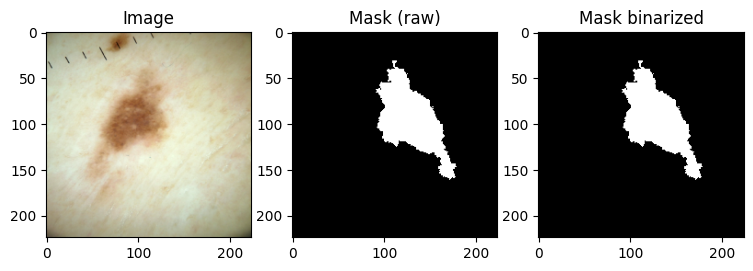

In [ ]:
train_ds = CacheDataset(data=train_files, transform=train_map, cache_rate=1.0, num_workers=2)
val_ds   = CacheDataset(data=val_files,   transform=val_map,   cache_rate=1.0, num_workers=2)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,  num_workers=2, pin_memory=torch.cuda.is_available())
val_loader   = DataLoader(val_ds,   batch_size=1, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

# Kiểm tra 1 batch
batch = next(iter(train_loader))
print("Image:", batch["image"].shape, "Label:", batch["label"].shape)

plt.figure(figsize=(9,3))
plt.subplot(1,3,1); plt.imshow(np.transpose(batch["image"][0].numpy(), (1,2,0))); plt.title("Image")
plt.subplot(1,3,2); plt.imshow(batch["label"][0,0].numpy(), cmap="gray"); plt.title("Mask (raw)")
plt.subplot(1,3,3); plt.imshow((batch["label"][0,0].numpy()>0.5).astype(float), cmap="gray"); plt.title("Mask binarized")
plt.show()


## Metrix

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# UNet 2D cho ảnh RGB
model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=3,     # ảnh RGB
    out_channels=1,    # nhị phân
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

# Kết hợp Dice + BCE để ổn định
dice_loss = DiceLoss(sigmoid=True)
bce_loss  = torch.nn.BCEWithLogitsLoss()

def combo_loss(pred, target, w_dice=0.5, w_bce=0.5):
    return w_dice * dice_loss(pred, target) + w_bce * bce_loss(pred, target)

optimizer   = torch.optim.Adam(model.parameters(), lr=1e-3)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

post_pred = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
post_label = Compose([AsDiscrete(threshold=0.5)])


## Train and Validation

In [ ]:
from tqdm import tqdm

max_epochs   = 12
val_interval = 2

best_metric = -1
best_epoch  = -1
writer = SummaryWriter()

for epoch in range(max_epochs):
    model.train()
    epoch_loss = 0
    for batch_data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs}"):
        images = batch_data["image"].to(device)
        labels = batch_data["label"].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = combo_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    print(f"[Train] Epoch {epoch+1} - Loss: {epoch_loss:.4f}")
    writer.add_scalar("train_loss", epoch_loss, epoch+1)

    if (epoch + 1) % val_interval == 0:
        model.eval()
        dice_metric.reset()
        with torch.no_grad():
            for val_data in val_loader:
                val_images = val_data["image"].to(device)
                val_labels = val_data["label"].to(device)

                val_outputs = model(val_images)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_targets = [post_label(i) for i in decollate_batch(val_labels)]
                dice_metric(y_pred=val_outputs, y=val_targets)

            metric = dice_metric.aggregate().item()
            dice_metric.reset()
            print(f"[Val ] Epoch {epoch+1} - Mean Dice: {metric:.4f}")
            writer.add_scalar("val_mean_dice", metric, epoch+1)

            if metric > best_metric:
                best_metric = metric
                best_epoch  = epoch + 1
                torch.save(model.state_dict(), "best_unet_isic.pth")
                print("✅ Saved new best model")

print(f"Hoàn tất! Best Dice: {best_metric:.4f} @ epoch {best_epoch}")
writer.close()


Epoch 1/12: 100%|██████████| 260/260 [16:12<00:00,  3.74s/it]


[Train] Epoch 1 - Loss: 0.6204


Epoch 2/12: 100%|██████████| 260/260 [16:16<00:00,  3.76s/it]

[Train] Epoch 2 - Loss: 0.5387


[Val ] Epoch 2 - Mean Dice: 0.7156
✅ Saved new best model


Epoch 3/12: 100%|██████████| 260/260 [16:17<00:00,  3.76s/it]


[Train] Epoch 3 - Loss: 0.4879


Epoch 4/12: 100%|██████████| 260/260 [16:35<00:00,  3.83s/it]

[Train] Epoch 4 - Loss: 0.4556


[Val ] Epoch 4 - Mean Dice: 0.7702
✅ Saved new best model


Epoch 5/12: 100%|██████████| 260/260 [16:08<00:00,  3.73s/it]


[Train] Epoch 5 - Loss: 0.4273


Epoch 6/12: 100%|██████████| 260/260 [16:54<00:00,  3.90s/it]

[Train] Epoch 6 - Loss: 0.3930


[Val ] Epoch 6 - Mean Dice: 0.7426


Epoch 7/12: 100%|██████████| 260/260 [16:42<00:00,  3.85s/it]


[Train] Epoch 7 - Loss: 0.3633


Epoch 8/12: 100%|██████████| 260/260 [16:48<00:00,  3.88s/it]

[Train] Epoch 8 - Loss: 0.3477


[Val ] Epoch 8 - Mean Dice: 0.7734
✅ Saved new best model


Epoch 9/12: 100%|██████████| 260/260 [16:05<00:00,  3.71s/it]


[Train] Epoch 9 - Loss: 0.3363


Epoch 10/12: 100%|██████████| 260/260 [16:55<00:00,  3.91s/it]

[Train] Epoch 10 - Loss: 0.3274


[Val ] Epoch 10 - Mean Dice: 0.7717


Epoch 11/12: 100%|██████████| 260/260 [16:32<00:00,  3.82s/it]


[Train] Epoch 11 - Loss: 0.3262


Epoch 12/12: 100%|██████████| 260/260 [16:10<00:00,  3.73s/it]

[Train] Epoch 12 - Loss: 0.3193


[Val ] Epoch 12 - Mean Dice: 0.7730
Hoàn tất! Best Dice: 0.7734 @ epoch 8


## Prediction Images

In [ ]:
def visualize_many(val_loader, model, device, n_samples=8, threshold=0.5, save_path=None):
    model.eval()
    ims, gts, preds = [], [], []
    with torch.no_grad():
        collected = 0
        for batch in val_loader:
            img = batch["image"].to(device)
            gt  = batch["label"].to(device)
            logits = model(img)
            prob = torch.sigmoid(logits)
            pred = (prob > threshold).float()

            img_np  = img.cpu().numpy()          # (B,C,H,W)
            gt_np   = gt.cpu().numpy()           # (B,1,H,W)
            pred_np = pred.cpu().numpy()         # (B,1,H,W)

            B = img_np.shape[0]
            for b in range(B):
                ims.append(img_np[b])
                gts.append(gt_np[b,0])
                preds.append(pred_np[b,0])
                collected += 1
                if collected >= n_samples:
                    break
            if collected >= n_samples:
                break

    rows = len(ims)
    fig, axes = plt.subplots(rows, 3, figsize=(12, 4*rows))
    if rows == 1:
        axes = np.expand_dims(axes, 0)

    for i in range(rows):
        # ảnh: nếu 1 kênh => (H,W), nếu 3 kênh => (H,W,3)
        if ims[i].shape[0] == 1:
            img_show = ims[i][0]
            axes[i,0].imshow(img_show, cmap="gray")
        else:
            img_show = np.transpose(ims[i], (1,2,0))
            axes[i,0].imshow(img_show)

        axes[i,0].set_title("Image")
        axes[i,1].imshow(gts[i], cmap="gray");  axes[i,1].set_title("Ground Truth")
        axes[i,2].imshow(preds[i], cmap="gray"); axes[i,2].set_title(f"Prediction (>{threshold})")

        for j in range(3):
            axes[i,j].axis("off")

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

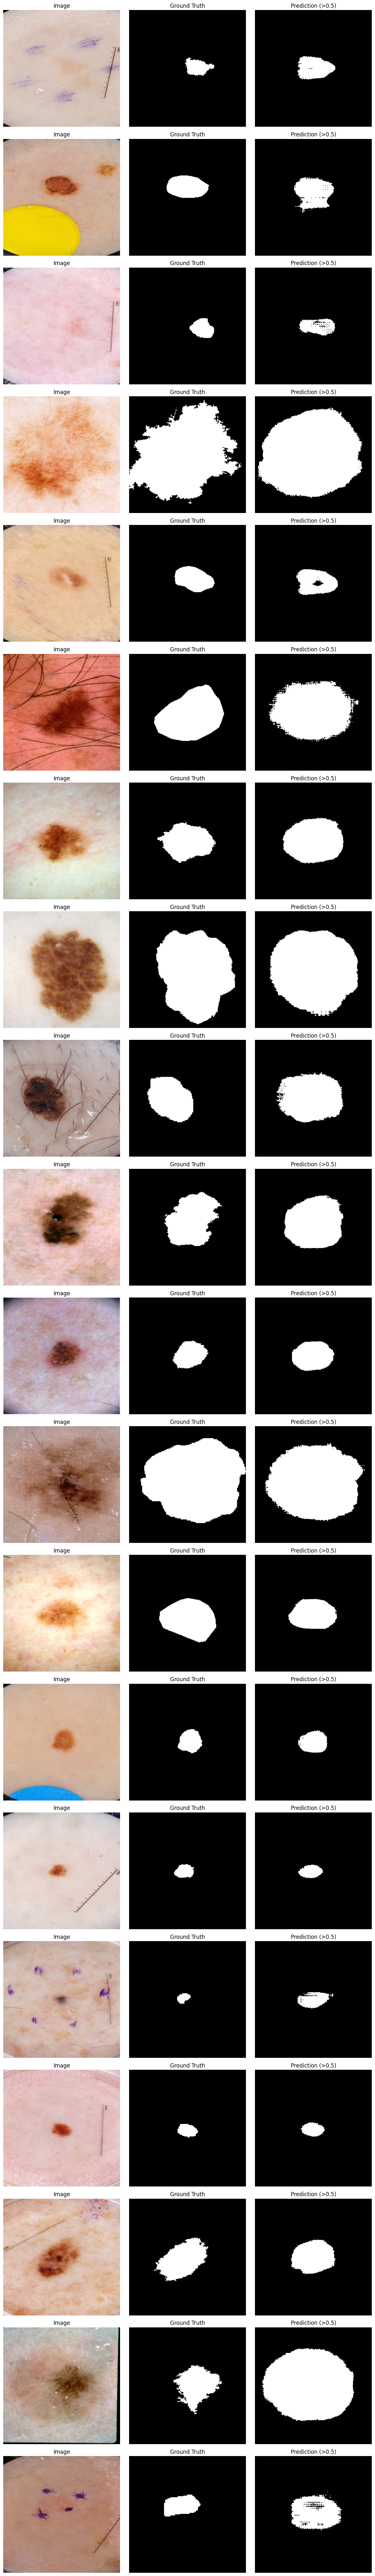

In [ ]:
visualize_many(val_loader, model, device, n_samples=20, threshold=0.5, save_path="val_grid.png")
